## <img src="./logo_UTN.svg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico Final
#### Valentín Pertierra

***
## Delimitación del intervalo QT mediante el análisis multiresolición de una señal de ECG  utilizando la trasformada wavelet
***

### Introducción
  
  

El análisis del electrocardiograma (ECG) es ampliamente utilizado para la detección  de enfermedades cardiacas.  Debido a que la mayor parte de la información clínica en el ECG se encuentra en los intervalos definidos por sus puntos característicos PQRST (Fig. 1), el desarrollo de métodos para la segmentación de la señal y la obtención de estos intervalos es de gran interés.  

En particular el estudio del segmento QT es de interés ya que hay evidencia que asocia este intervalo con arritmias cardiacas letales [1]. En primer lugar se evidencio la asoció entre el intervalo QT prolongado y el síncope, la muerte súbita abortada, y su nexo con las arritmias ventriculares, tales como las taquicardias ventriculares polimórficas y la fibrilación ventricular[2][3]. Posteriormente se asoció al intervalo QT corto con la muerte súbita [4].  



<img src="./segmentosECG.png" align="center" width="50%" />

Fig.1: Puntos característicos de un latido normal y sus intervalos asociados 

La estructura de un algoritmo para el procesamiento de una señal de ECG posee diferentes etapas [5] las cuales consisten en realizar un pre procesamiento de la señal, posteriormente se detecta el complejo QRS y tomando como referencia su ubicación se hace la segmentación de los intervalos de interes (Fig. 2).

<img src="./diagramaEnBloques.png" align="center" width="50%" />

Fig.2: Estructura básica para el procesamiento de una señal de ECG.

En primer lugar es necesario realizar un acondicionamiento de la señal de ECG mediante el filtrado de la línea de base. Esta señal interferente es causada por la respiración, la contracción muscular  y el cambio de la impedancia de los electrodos producto del movimiento del sujeto durante la prueba de esfuerzo.  

El complejo QRS es la curva más característica dentro de la señal de ECG y su detección es utiliza como una referencia dentro del ciclo cardíaco. Debido a su amplitud, la detección de la onda R es sencilla en comparación con las otras y a partir de su ubicación, se prosigue con la delimitación de las ondas caracteristicas (P y T) y los diferentes segmentos de interés.     


En este trabajo se utilizara la Trasformada Tiempo-Escala (Wavelet) para la detección del complejo QRS y la obtención del segmento QT. La Transformada Wavelet es una trasformación lineal que descompone una señal $ x(t) $, por medio de la dilatación $ (s) $ y traslación $ (\tau) $ de una función wavelet prototipo $ \psi(t) $ tal que:  


$$ w(s,\tau)=\int_{-\infty}^{\infty}x(t)\frac{1}{\sqrt{s}}\psi\left ( \frac{t-\tau }{s} \right )dt $$  

A medida que disminuye el factor de escala $ s $, el soporte de la wavelet disminuye y la trasformada se vuelve más sensible a las componentes de alta frecuencia de la señal. De forma opuesta, a medida que el factor de escala aumente, el soporte de la wavelet se expande y la trasformada da información de las componentes de baja frecuencia. De esta manera podemos realizar el análisis de una señal en múltiples escalas y con diferentes resoluciones. En este sentido, la resolución temporal es mayor para las componentes de alta frecuencia y disminuye para las de baja frecuencia.  


La elección de la wavelet prototipo no es trivial, ya que hay una gran variedad y cada una de ellas favorece la extracción diferentes características de la señal analizada. Se utilizara como wavelet prototipo la primer derivada de la función Gaussiana (Fig. 3) propuesta en [6]. Al utilizar la derivada de una función suave (función que admite derivadas de cualquier orden) se obtiene como característica que el cruce por cero de la trasformada corresponde con la posición del máximo o mínimo local de la señal en diferentes escalas y el valor absoluto máximo de la transformada está asociado con la pendiente de la señal [7].  

<img src="./waveletPrototipo.png" align="left" width="40%" /> <img src="./fourierWavelet.png" align="center" width="39%" />  


Fig.3: Función Gaussiana $ \theta(t) $ y Wavelet prototipo $ \psi(t) $ (a). Transformada de Fourier de la wavelet en diferentes escalas (b).   





In [160]:
# Inicialización del notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import OffsetFrom
from pandas import DataFrame
from IPython.display import HTML
from scipy import signal as sig
import scipy.io as sio
import pywt

In [2]:
# Cargo el ECG obtenido en una prueba de esfuerzo
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = np.reshape(ecg_one_lead,len(ecg_one_lead))

# Ubicación conocida del complejo QRS 
posQRS = mat_struct['qrs_detections']
posQRS = np.reshape(posQRS,len(posQRS))

# Cantidad de muestras
N = len(ecg_one_lead)

# Frecuencia de muestreo
fs = 1000
fn = fs/2

### Filtrado del movimiento de línea de base

Filtro la señal interferente utilizando un filtro de mediana. Como el tiempo de procesamiento es considerable, en primer lugar realizo un diezmado de la señal de ECG y luego elimino la señal de línea de base con dos filtros de mediana. De esta forma disminuye la cantidad de muestras a filtrar, aumentando la velocidad de procesamiento.


In [3]:
# Adopto como nueva frecuencia de Nyquist fn2 = 10Hz  =>  fs2=20Hz
# Antes de diezmar la señal la tengo que filtrar para impedir que se meta alias
# Determino las caracteristicas del filtro digital
fp0 = 10
fs0 = 11
attPaso = 0.1
attStop = 100

# Obtengo los parametros del filtro
bpSosButter = sig.iirdesign(wp=fp0/fn,ws=fs0/fn,gpass=attPaso,gstop=attStop,analog=False,ftype='butter',output='sos')
wB,hB = sig.sosfreqz(bpSosButter, worN=1500)

# Filtro la señal original 
ecgB = sig.sosfiltfilt(bpSosButter, ecg_one_lead) 

# Diezmo la señal, la muestreo  a fs2 = 20Hz => 50 veces menos que fs1=1000Hz
fs2 = 20
fn2 = fs2/2
ecgD = ecgB[0:N:50]
N2 = len(ecgD)

# Le aplico el primer filtro de mediana de 3 muestras
ecgD_med3 = sig.medfilt(ecgD,3)

# Le aplico el segundo filtro de mediana de 17 muestras
estBD = sig.medfilt(ecgD_med3,17)

# Interpolo ceros en el estimador de la señal interferente obtenido
estBZ = np.zeros(N)
estBZ[0:N:50] = estBD
estBZ[0] = 0

# Filtro la señal interpolada
estBmr = sig.sosfiltfilt(bpSosButter, estBZ) 

# Escalo la señal resultante
maxBZ = np.max(estBZ)
estBmr = maxBZ*estBmr/np.max(estBmr)

# Le resto la interferente a la señal de ecg original
est_ecg = ecg_one_lead - estBmr

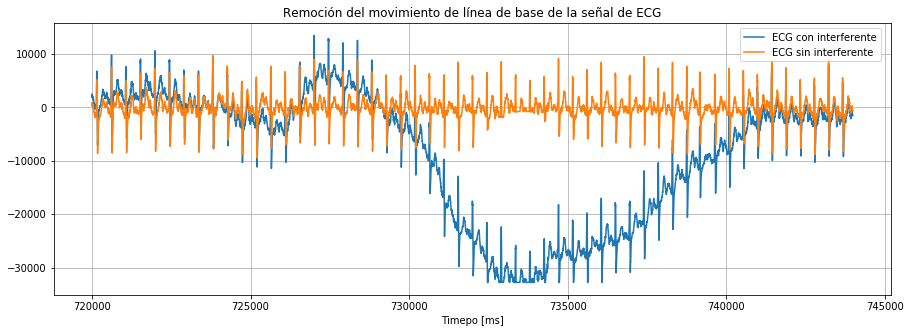

In [273]:
# Grafico una región de la señal de ECG antes y después de eliminar la señal interferente
region = np.arange(720000, 744000)

plt.figure(figsize=(15,5))
plt.title("Remoción del movimiento de línea de base de la señal de ECG")
plt.plot(region,ecg_one_lead[region],label= "ECG con interferente")
plt.plot(region,est_ecg[region],label= "ECG sin interferente")
plt.xlabel("Timepo [ms]")
plt.legend(bbox_to_anchor=(0.82, 0.98), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

### Detección del complejo QRS

La detección del complejo QRS se basas en la detección de valores de la transformada wavelet que superan un determinado valor umbral y, a partir de ese valor, se busca el punto donde la trasformada se hace cero. El cruce por cero de la transformada coincide con la onda R.  
   
   
La mayor cantidad de energía del complejo QRS se concentra en la banda de frecuencias de 3Hz a 40Hz, esto se corresponde con las escalas $ s $ entre 8 y 16 (Fig. 3 b). En este caso se utilizar la escala  $ s = 8 $


In [44]:
# Realizo la transformada wavelet de la señal de ECG filtrada utilizando 
# como wavelet madre la primer derivada de una señal gaussiana.
wt8, freqs = pywt.cwt(est_ecg, [8], 'gaus1')
wt8 = np.transpose(wt8)
wt8 = wt8/np.max(wt8)

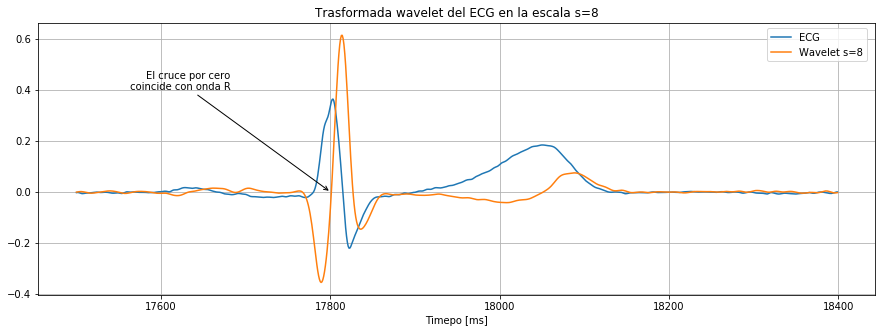

In [170]:
# Grafico la tranformada wavelet en la escala s=8
region = np.arange(17500,18400)

fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Trasformada wavelet del ECG en la escala s=8")

ax.plot(region,est_ecg[region]/np.max(est_ecg),label= "ECG")
ax.plot(region,wt8[region],label= "Wavelet s=8")

ax.annotate('El cruce por cero\n coincide con onda R',
            xy=(17800,0), xycoords='data',
            xytext=(-100, 100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='right', verticalalignment='bottom')

ax.set_xlabel("Timepo [ms]")
ax.legend(bbox_to_anchor=(0.87, 0.98), loc=2, borderaxespad=0.)
ax.grid(True)


In [4]:
# Detecto la onda R
# Defino constantes del algoritmo
TIME_OFF = 300   # Tiempo que no detecto niveles superiores al umbral despues de superar uno
VENT_WIDTH = 40  # Ventana en donde se busca el cruce por cero de la wt8
R_TRH = 0.22     # Umbral de detección de la onda R

cont = 0
flag = 0
cruceCero = 0

detectR = []
for i in range(len(wt8)):
    
    if flag != 1:
        # Detecto los pulsos que superan el umbral
        if wt8[i] >= R_TRH:   
            
            # Obtengo el minimo local dentro de una ventana a partir del valor que supera el umbral
            minLocal = np.argmin(wt8[i-VENT_WIDTH:i])
            
            # Detecto el cruce por cero
            cruceCero = np.argmin(np.abs(wt8[i-minLocal:i]))
            detectR.append(i-minLocal+cruceCero)
            
            flag = 1
    else:
        cont = cont+1
        if cont == TIME_OFF:
            cont = 0
            flag = 0

detectR = np.transpose(np.array(detectR))

In [270]:
# Obtengo las métricas del algoritmo de detección
# Genero un array del largo del ecg en el cual pongo en 1 el lugar donde hay un latido
refR = np.zeros(N)              # Posición de los latidos del archivo 'qrs_detections'
detR = np.zeros(N)              # Posición de los latidos detectados con mi algoritmo

for i in posQRS:
    refR[i] = 1
    
for i in detectR:
    detR[i] = 1
    
FP = 0      # Falso Positovo
FN = 0      # Falso Negativo
VP = 0      # Verdadero Positivo
dt = 30     # Margen dentro del cual concidero válido el latido detectado

for i in posQRS:
    if np.sum(detR[i-dt:i+dt]) == 1:
        VP = VP+1
    else:
        FN = FN+1
        
for i in detectR:
    if np.sum(refR[i-dt:i+dt]) == 0:
        FP = FP+1

acc = VP/len(posQRS)    # Exactitud
vpp = VP/(VP+FP)        # Valor predictivo positivo
S = VP/(VP+FN)          # Sensibilidad

# El FN y FP dan distinto de cero 
# pero encontre que falta un latido cerca de 248000 en los latidos detectados que asumo como verdaderos

df = DataFrame([[str(dt)+"ms"],[str(len(posQRS))],[str(VP)],[str(FP)],[str(FN)],["%.2f"%(acc*100)+"%"],["%.2f"%(vpp*100)+"%"],["%.2f"%(S*100)+"%"]], columns=['Métricas'],
               index=["Ventana de tiempo", 
                      "Cantidad total de latidos", 
                      "Verdadero-Positovo (VP)", 
                      "Falso-Positivo (FP)",
                      "Falso-Negativo (FN)",
                      "Exactitud",
                      "Valor predictivo positivo",
                      "Sensibilidad"
                     ])
HTML(df.to_html())


,Métricas
Ventana de tiempo,30ms
Cantidad total de latidos,1903
Verdadero-Positovo (VP),1902
Falso-Positivo (FP),2
Falso-Negativo (FN),1
Exactitud,99.95%
Valor predictivo positivo,99.89%
Sensibilidad,99.95%


Según esta métrica no se detectaron la totalidad de los latidos. Hay un latido que el algoritmo no detecto y dos que detecto pero que no se encuentran.  
En realidad se encontró que hay una ubicación de un latido en 'qrs_detections' que pertenece a una onda T y que se asume como R.


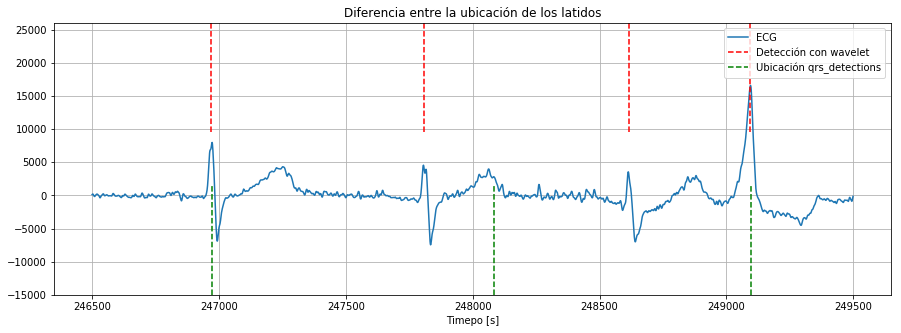

In [5]:
# Grafico el latido que no esta detectado en 'qrs_detections'

region = np.arange(246500,249500)

plt.figure(figsize=(15,5))
plt.title("Diferencia entre la ubicación de los latidos")
plt.plot(region,est_ecg[region],label= "ECG")

indice = np.argwhere(detectR>region[0])
indFin = 3

plt.axvline(x=detectR[indice[0]],ymin=0.6,ymax=1,color = 'r', linestyle='--',label = "Detección con wavelet")
plt.axvline(x=posQRS[indice[0]],ymin=0,ymax=0.4,color = 'g', linestyle='--',label = "Ubicación qrs_detections")

for xc in detectR[indice[1:indFin+1]]:
    plt.axvline(x=xc,ymin=0.6,ymax=1,color = 'r', linestyle='--')
   
for xc in posQRS[indice[1:indFin]]:
    plt.axvline(x=xc,ymin=0,ymax=0.4,color = 'g', linestyle='--')

plt.ylim(-15000, 26000)
plt.xlabel("Timepo [ms]")
plt.legend(bbox_to_anchor=(0.80, 0.98), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

Por esta diferencia entre la ubicación de los latidos que supongo verdadera y la detectada con el algoritmo, asumo que se están detectando todos los latidos correctamente.

A continuación se realiza una clasificación de los latidos detectados, son agrupados en dos categorías: latidos normales y ventriculares. Esta clasificación es necesaria ya que el intervalo QT se obtiene de los latidos normales.
  
Se observó que en la escala 128 de la trasformada wavelet del ECG los latidos ventriculares presentan una mayor amplitud respecto a los normales. Por consiguiente, al comparar el nivel de la trasformada en las posiciones donde hay latidos se puede determinar la naturaleza del mismo.


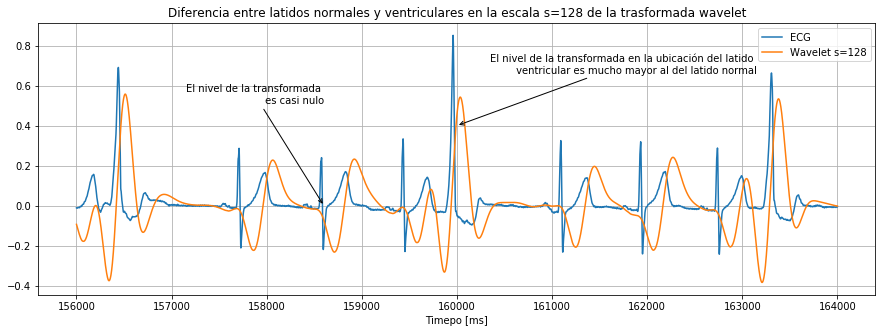

In [256]:
# Realizo la trasformada wavelet del ECG en la escala 128 
wt128, freqs = pywt.cwt(est_ecg, [128], 'gaus1')
wt128 = np.transpose(wt128)
wt128 = wt128/np.max(wt128)

# Grafico la diferencia entre los latidos normales y ventriculares en esta escala
region = np.arange(156000,164000)

fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Diferencia entre latidos normales y ventriculares en la escala s=128 de la trasformada wavelet")

ax.plot(region,est_ecg[region]/np.max(est_ecg),label= "ECG")
ax.plot(region,wt128[region],label= "Wavelet s=128")

ax.annotate('El nivel de la transformada en la ubicación del latido \n ventricular es mucho mayor al del latido normal',
            xy=(160000,0.4), xycoords='data',
            xytext=(300, 50), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='right', verticalalignment='bottom')

ax.annotate('El nivel de la transformada \n es casi nulo',
            xy=(158600,0), xycoords='data',
            xytext=(0, 100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='right', verticalalignment='bottom')

ax.set_xlabel("Timepo [ms]")
ax.legend(bbox_to_anchor=(0.86, 0.98), loc=2, borderaxespad=0.)
ax.grid(True)


In [12]:
# Clasifico los latidos detectados entre normales y ventriculares
VENTR_THR = 0.2     # Umbral para detectar latidos ventriculares
VENT_WIDTH = 40

pLatNorm = []
pLatVentr = []

for r in detectR:
    
    if np.max(wt128[r:r+VENT_WIDTH]) > VENTR_THR:
        pLatVentr.append(r)
    else:
        pLatNorm.append(r)

pLatVentr = np.transpose(np.array(pLatVentr))
pLatNorm = np.transpose(np.array(pLatNorm))

Al no tener una clasificación previa y verificada de los latidos, no puedo generar ninguna métrica que permita describir el desempeño del algoritmo.   
Para realizar una prueba empírica del correcto funcionamiento del algoritmo lo que se hizo fue generar un gráfico con todos los latidos, tanto normales como ventriculares, superpuestos. De  esta forma se puede determinar si se clasificaron latidos ventriculares como normales o viceversa mediante la observación de latidos que no pertenecen a la categoría en los gráficos.    


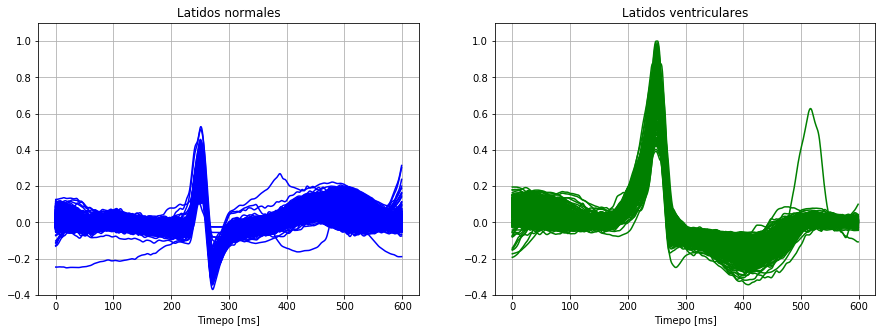

In [14]:
# Grafico en forma superpuesta los latidos clasificados
# Ancho de la venta que voy a mostrar
dtp = 350
dtn = 250

# Obtengo el valor máximo para normalizar la señales
maxECG = np.max(est_ecg)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Latidos normales")
for norm in pLatNorm:
    plt.plot(np.arange(dtn+dtp),est_ecg[norm-dtn:norm+dtp]/maxECG,color = 'b')
plt.grid(True)
plt.ylim(-0.4,1.1)
plt.xlabel("Timepo [ms]")
  
plt.subplot(1,2,2)
plt.title("Latidos ventriculares")
for ventr in pLatVentr:
    plt.plot(np.arange(dtn+dtp),est_ecg[ventr-dtn:ventr+dtp]/maxECG,color = 'g')  
plt.ylim(-0.4,1.1)
plt.grid(True)
plt.xlabel("Timepo [ms]")

plt.show()

Mediante una inspección visual se puede concluir que el algoritmo de clasificación funciona correctamente. No se observan latidos ventriculares dentro del conjunto de latidos normales o viceversa.  

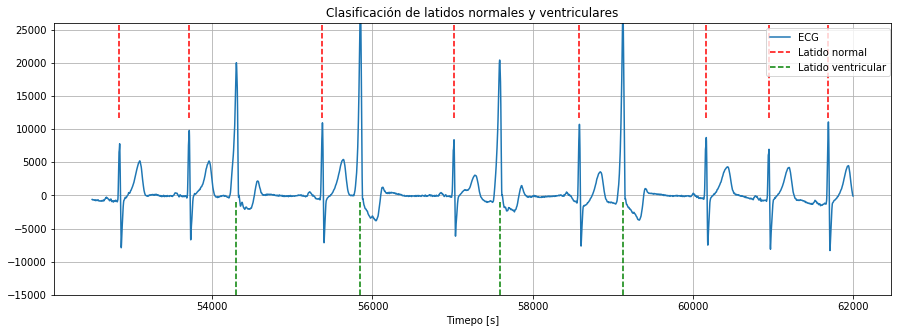

In [156]:
# Grafico una región que contenga latido normales y ventriculares
region = np.arange(52500,62000)

plt.figure(figsize=(15,5))
plt.title("Clasificación de latidos normales y ventriculares")
plt.plot(region,est_ecg[region],label= "ECG")

indiceN = np.argwhere(pLatNorm>region[0])
indiceV = np.argwhere(pLatVentr>region[0])
indFin = 4

plt.axvline(x=pLatNorm[indiceN[0]],ymin=0.65,ymax=1,color = 'r', linestyle='--',label = "Latido normal")
plt.axvline(x=pLatVentr[indiceV[0]],ymin=0,ymax=0.35,color = 'g', linestyle='--',label = "Latido ventricular")

for xc in pLatNorm[indiceN[1:indFin+4]]:
    plt.axvline(x=xc,ymin=0.65,ymax=1,color = 'r', linestyle='--')
   
for xc in pLatVentr[indiceV[1:indFin]]:
    plt.axvline(x=xc,ymin=0,ymax=0.35,color = 'g', linestyle='--')

plt.ylim(-15000, 26000)
plt.xlabel("Timepo [ms]")
plt.legend(bbox_to_anchor=(0.85, 0.98), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

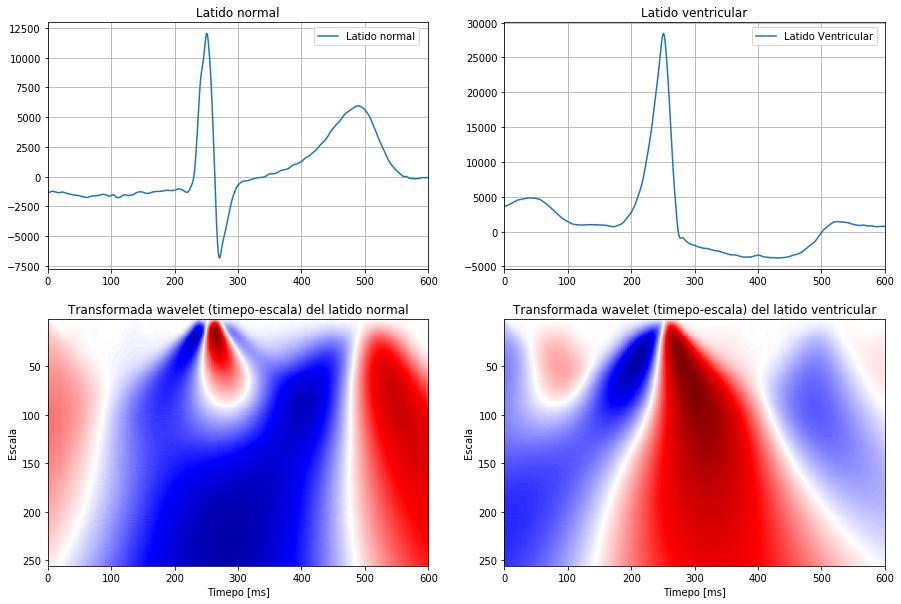

In [277]:
# Región donde estan los latidos normales y ventriculares
regAnalisisNorm = est_ecg[pLatNorm[2]-dtn:pLatNorm[2]+dtp]
regAnalisisVentr = est_ecg[pLatVentr[3]-dtn:pLatVentr[3]+dtp]

# Realizo la transformada wavelet continua de las regiones donde se ubican los latidos
widths = np.arange(1,256)
cwtMatrNorm, freqs = pywt.cwt(regAnalisisNorm, widths, 'gaus1')
cwtMatrVentr, freqs = pywt.cwt(regAnalisisVentr, widths, 'gaus1')

# Grafico las señales y sus transformadas
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("Latido normal")
plt.plot(np.arange(len(regAnalisisNorm)),regAnalisisNorm,label= "Latido normal")
plt.legend(bbox_to_anchor=(0.70, 0.98), loc=2, borderaxespad=0.)
plt.xlim(0, dtn+dtp)
plt.grid(True)

plt.subplot(2,2,2)
plt.title("Latido ventricular")
plt.plot(np.arange(len(regAnalisisVentr)),regAnalisisVentr,label= "Latido Ventricular")
plt.legend(bbox_to_anchor=(0.65, 0.98), loc=2, borderaxespad=0.)
plt.xlim(0, dtn+dtp)
plt.grid(True)

plt.subplot(2,2,3)
# Para los colores de la escala ver: https://matplotlib.org/examples/color/colormaps_reference.html
plt.title("Transformada wavelet (timepo-escala) del latido normal")
plt.imshow(cwtMatrNorm, extent=[0, len(regAnalisisNorm),256,1], cmap='seismic', aspect='auto',vmax=abs(cwtMatrNorm).max(), vmin=-abs(cwtMatrNorm).max())   
plt.xlabel("Timepo [ms]")
plt.ylabel("Escala")
#plt.colorbar()

plt.subplot(2,2,4)
plt.title("Transformada wavelet (timepo-escala) del latido ventricular")
plt.imshow(cwtMatrVentr, extent=[0, len(regAnalisisVentr),256,1], cmap='seismic', aspect='auto',vmax=abs(cwtMatrVentr).max(), vmin=-abs(cwtMatrVentr).max())   
plt.xlabel("Timepo [ms]")
plt.ylabel("Escala")
#plt.colorbar()

plt.show()

En la imagen anterior se puede ver como en las escalas bajas la transformada wavelet es más sensible a las componentes de alta frecuencia y a medida que aumenta la escala se hace más sensible a las componentes de baja frecuencia.  

### Detección del segmento QT

La delimitación del segmento QT se obtiene a partir de la ubicación de la onda R de los latidos normales. Para identificar el inicio de la onda Q se busca el mínimo local de la transformada ubicado antes de la onda R, a partir de ese valor se recorre la transformada hacia atrás hasta alcanzar un valor correspondiente a una fracción del módulo del mínimo local y a ese punto se lo considera el inicio de la onda Q. De manera similar se detecta el fin de la onda T, en este caso se busca el segundo máximo local de la trasformada después de la ubicación de R, a partir de ese punto se recorre la trasformada hacia adelante hasta alcanzar una fracción del módulo máximo.  

Para el caso de la detección del inicio de la onda Q se utilizó la escala $ s = 4 $ y para el fin de la onda T se utilizó la escala  $ s = 32 $.


In [19]:
# Realizo la trasformada en las escalas 4 y 32
wt4, freqs = pywt.cwt(est_ecg, [4], 'gaus1')
wt4 = np.transpose(wt4)
wt4 = wt4/np.max(wt4)

wt32, freqs = pywt.cwt(est_ecg, [32], 'gaus1')
wt32 = np.transpose(wt32)
wt32 = wt32/np.max(wt32)

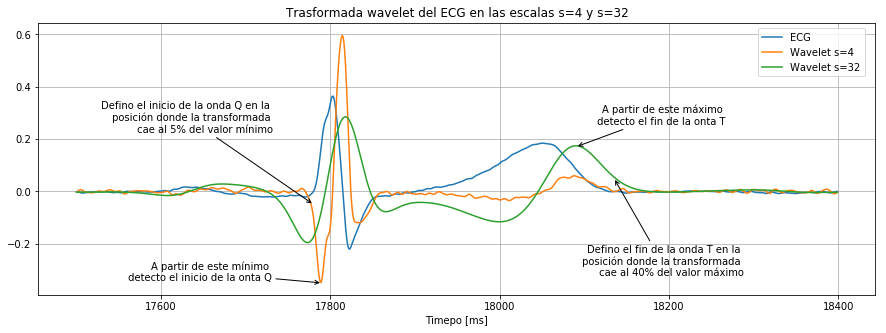

In [274]:
# Grafico las señales obtenidas
region = np.arange(17500,18400)

fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Trasformada wavelet del ECG en las escalas s=4 y s=32")
ax.plot(region,est_ecg[region]/np.max(est_ecg),label= "ECG")
ax.plot(region,wt4[region],label= "Wavelet s=4")
ax.plot(region,wt32[region],label= "Wavelet s=32")

ax.annotate('A partir de este mínimo \n detecto el inicio de la onta Q',
            xy=(17790,-0.35), xycoords='data',
            xytext=(-50, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='right', verticalalignment='bottom')

ax.annotate('Defino el inicio de la onda Q en la \n posición donde la transformada \n cae al 5% del valor mínimo',
            xy=(17780,-0.05), xycoords='data',
            xytext=(-40, 70), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='right', verticalalignment='bottom')

ax.annotate('A partir de este máximo \n detecto el fin de la onta T',
            xy=(18090,0.17), xycoords='data',
            xytext=(150, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='right', verticalalignment='bottom')

ax.annotate('Defino el fin de la onda T en la \n posición donde la transformada \n cae al 40% del valor máximo',
            xy=(18135,0.05), xycoords='data',
            xytext=(130, -100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='right', verticalalignment='bottom')

ax.set_xlabel("Timepo [ms]")
ax.legend(bbox_to_anchor=(0.86, 0.98), loc=2, borderaxespad=0.)
ax.grid(True)

In [218]:
# Defino las constantes del algoritmo
Q_THR = 0.05   # Umbral para detectar el inicio de la onda Q
T_THR = 0.4    # Umbral para detectar el fin de la onta T

VENT_WIDTH_Q =  60
VENT_WIDTH_T_FIN =  300
VENT_WIDTH_T_INI =  100

# Determino el inicio de la onda Q 
inicioQ = []

for r in pLatNorm:
    
    # Detecto el mínimo local
    minLoc = np.argmin(wt4[r-VENT_WIDTH_Q:r])
    wt4MaxMod = np.abs(wt4[r-VENT_WIDTH_Q+minLoc])
    
    for i in range(minLoc-1,-1,-1):
        if np.abs(wt4[r-VENT_WIDTH_Q+i]) <= wt4MaxMod*Q_THR:
            inicioQ.append(r-VENT_WIDTH_Q+i)
            break

inicioQ = np.transpose(np.array(inicioQ))

# Determino en fin de la onda T
finT = []           

for r in pLatNorm:
    
    # Detecto el máximo local perteneciente a la onda T
    maxLoc = np.argmax(wt32[r+VENT_WIDTH_T_INI:r+VENT_WIDTH_T_FIN])
    wt32MaxMod = np.abs(wt32[r+maxLoc])
    
    for i in range(VENT_WIDTH_T_FIN-VENT_WIDTH_T_INI):
        if np.abs(wt32[r+VENT_WIDTH_T_INI+maxLoc+i]) <= wt32MaxMod*T_THR:
            finT.append(r+VENT_WIDTH_T_INI+maxLoc+i)
            break

finT = np.transpose(np.array(finT))

C:\Users\Valentin\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


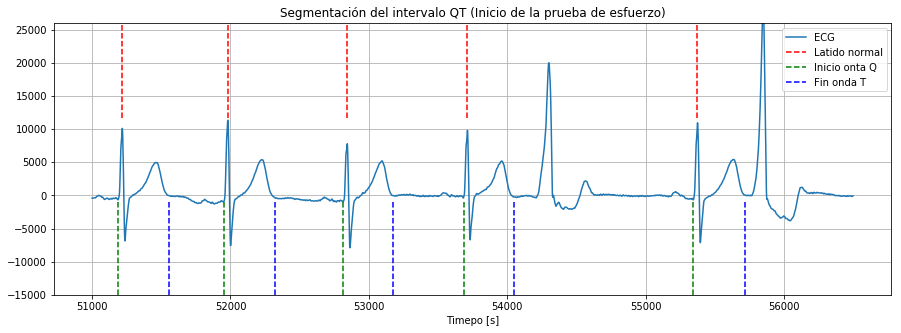

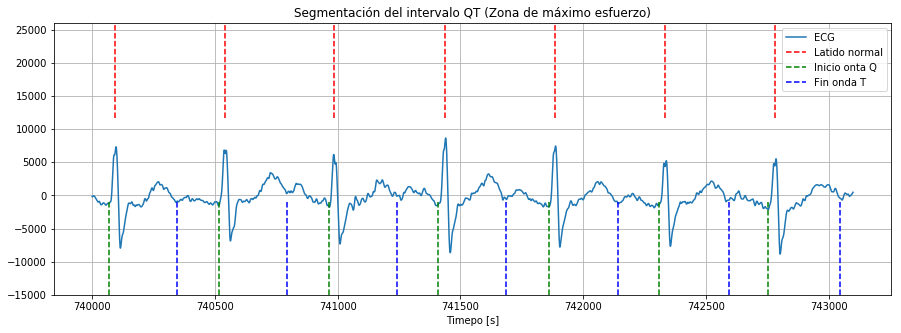

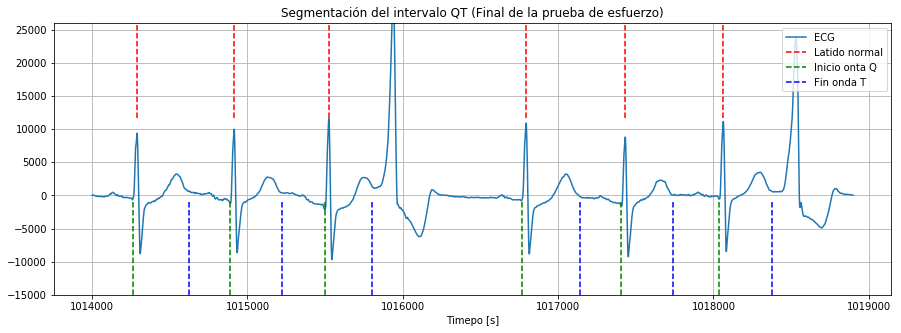

In [219]:
# Grafico una región del ECG y la segmentación del intervalo QT 

regiones = [np.arange(51000,56500),np.arange(740000,743100),np.arange(1014000,1018900)]
titles = ["(Inicio de la prueba de esfuerzo)","(Zona de máximo esfuerzo)","(Final de la prueba de esfuerzo)"]
indiceFin = [5,7,6]

for region in regiones:
    
    i = regiones.index(region)
    
    plt.figure(figsize=(15,5))
    plt.title("Segmentación del intervalo QT "+titles[i])
    plt.plot(region,est_ecg[region],label= "ECG")

    indiceN = np.argwhere(pLatNorm>region[0])
    indiceQ = np.argwhere(inicioQ>region[0])
    indiceT = np.argwhere(finT>region[0])
    indFin = indiceFin[i]

    plt.axvline(x=pLatNorm[indiceN[0]],ymin=0.65,ymax=1,color = 'r', linestyle='--',label = "Latido normal")
    plt.axvline(x=inicioQ[indiceQ[0]],ymin=0,ymax=0.35,color = 'g', linestyle='--',label = "Inicio onta Q")
    plt.axvline(x=finT[indiceT[0]],ymin=0,ymax=0.35,color = 'b', linestyle='--',label = "Fin onda T")

    for xc in pLatNorm[indiceN[1:indFin]]:
        plt.axvline(x=xc,ymin=0.65,ymax=1,color = 'r', linestyle='--')

    for xc in inicioQ[indiceQ[1:indFin]]:
        plt.axvline(x=xc,ymin=0,ymax=0.35,color = 'g', linestyle='--')

    for xc in finT[indiceT[1:indFin]]:
        plt.axvline(x=xc,ymin=0,ymax=0.35,color = 'b', linestyle='--')

    plt.ylim(-15000, 26000)
    plt.xlabel("Timepo [s]")
    plt.legend(bbox_to_anchor=(0.87, 0.98), loc=2, borderaxespad=0.)
    plt.grid(True)


### Obtención del tacograma y curva de intervalos QT

El tacograma (curva de intervalos RR) representa el tiempo del ciclo cardíaco, medido entre dos ondas R consecutivas y sirve como un indicador de la frecuencia cardíaca.

In [104]:
# Obtengo el tacograma (curva de intervalos R-R)
intervaloRR = []

for i in range(len(detectR)-1):   
    intervaloRR.append(detectR[i+1]-detectR[i])
    
intervaloRR = np.transpose(np.array(intervaloRR))

# Filtro de mediana 1
#tacograma = sig.medfilt(intervaloRR,9)
tacograma = sig.medfilt(intervaloRR,25)

# Filtro de media movil
ventana = 8
tacograma = np.convolve(tacograma, np.ones((ventana,))/ventana, mode='valid')

# Filtro de mediana 2
tacograma = sig.medfilt(tacograma,5)

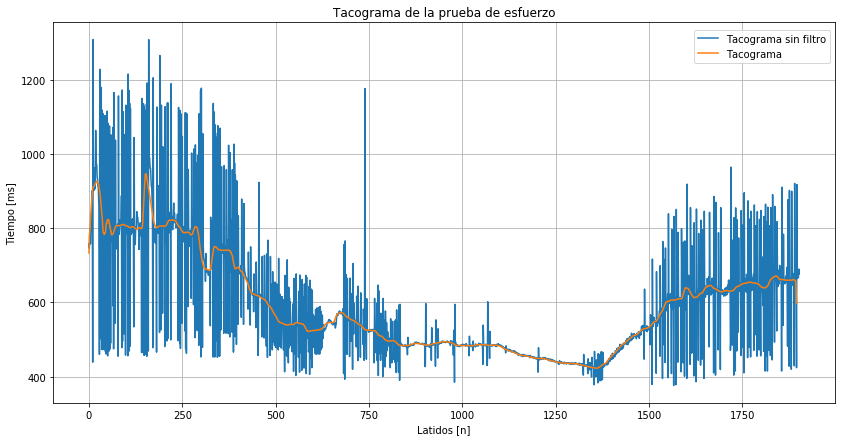

In [124]:
# Grafico el tacograma
plt.figure(figsize=(14,7))
plt.title("Tacograma de la prueba de esfuerzo")
plt.plot(np.arange(len(intervaloRR)),intervaloRR,label= "Tacograma sin filtro")
plt.plot(np.arange(len(tacograma)),tacograma,label= "Tacograma")
plt.legend(bbox_to_anchor=(0.82, 0.98), loc=2, borderaxespad=0.)
plt.xlabel("Latidos [n]")
plt.ylabel("Tiempo [ms]")
plt.grid(True)
plt.show()

El valor mínimo del tacograma representa la máxima frecuencia cardiaca y se encuentra en el punto de máximo esfuerzo.  

In [92]:
# Obtengo la curva de intervalos QT
intervaloQT = []
for i in range(len(pLatNorm)-1):   
    intervaloQT.append(finT[i]-inicioQ[i])

interQT = np.transpose(np.array(intervaloQT))

# Filtro de mediana
intervaloQT = sig.medfilt(interQT,25)

# Como el segmento QT se extrae de los latidos normales interpolo los latidos ventriculares
intervaloQT2 = []
i=0
for r in detectR[:-1]:   
    
    if r in pLatNorm.tolist():
        intervaloQT2.append(intervaloQT[i])
        i = i+1
    else:
        intervaloQT2.append(intervaloQT[i-1])     
intervaloQT = np.transpose(np.array(intervaloQT2))

# Filtro de media movil
ventana = 8
intervaloQT = np.convolve(intervaloQT, np.ones((ventana,))/ventana, mode='valid')

# Filtro de mediana
intervaloQT = sig.medfilt(intervaloQT,3)

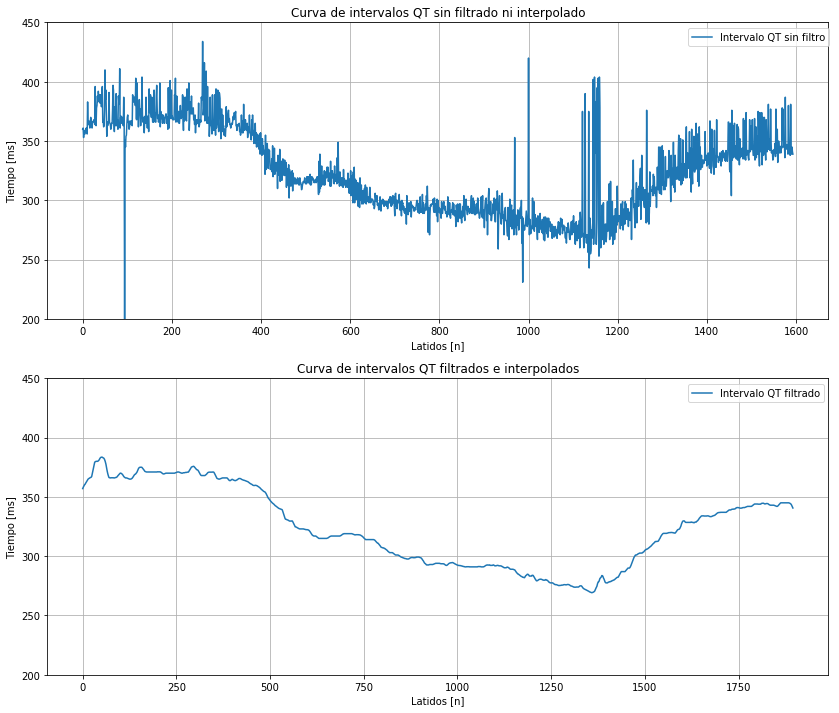

In [102]:
plt.figure(figsize=(14,12))

plt.subplot(2,1,1)
plt.title("Curva de intervalos QT sin filtrado ni interpolado")
plt.plot(np.arange(len(interQT)),interQT,label= "Intervalo QT sin filtro")
plt.legend(bbox_to_anchor=(0.82, 0.98), loc=2, borderaxespad=0.)
plt.xlabel("Latidos [n]")
plt.ylabel("Tiempo [ms]")
plt.ylim(200, 450)
plt.grid(True)

plt.subplot(2,1,2)
plt.title("Curva de intervalos QT filtrados e interpolados")
plt.plot(np.arange(len(intervaloQT)),intervaloQT,label= "Intervalo QT filtrado")
plt.legend(bbox_to_anchor=(0.82, 0.98), loc=2, borderaxespad=0.)
plt.xlabel("Latidos [n]")
plt.ylabel("Tiempo [ms]")
plt.ylim(200, 450)
plt.grid(True)

plt.show()

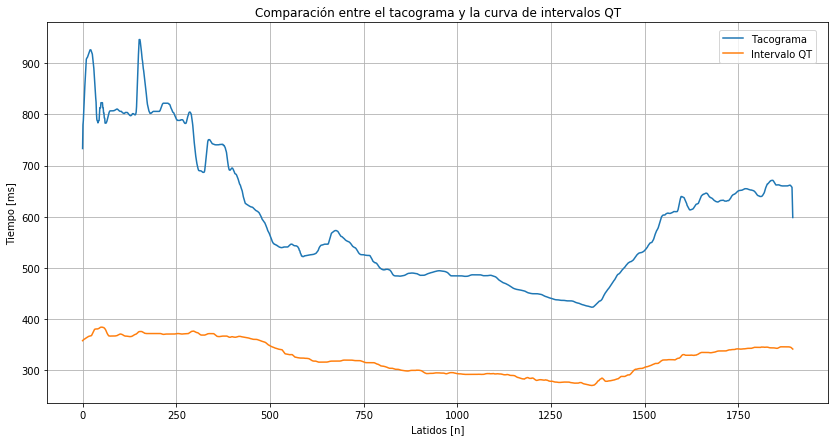

In [278]:
# Grafico el tacograma junto a la curva de intervalos QT
plt.figure(figsize=(14,7))
plt.title("Comparación entre el tacograma y la curva de intervalos QT")

plt.plot(np.arange(len(tacograma)),tacograma,label= "Tacograma")
plt.plot(np.arange(len(intervaloQT)),intervaloQT,label= "Intervalo QT")

plt.legend(bbox_to_anchor=(0.86, 0.98), loc=2, borderaxespad=0.)
plt.xlabel("Latidos [n]")
plt.ylabel("Tiempo [ms]")
plt.grid(True)
plt.show()



En este gráfico se puede observar que existe una relación entre la frecuencia cardíaca y el intervalo QT. A medida que la frecuencia cardíaca aumente, disminuye el intervalo QT y viceversa.  

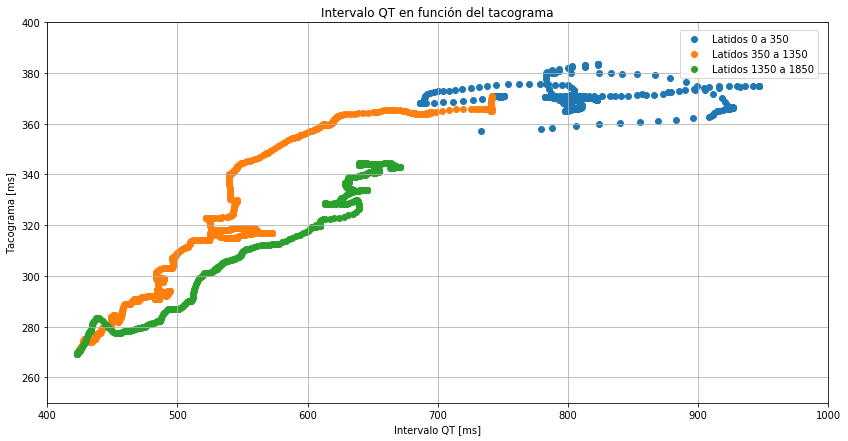

In [280]:

region_1 = np.arange(0,350)
region_2 = np.arange(350,1350)
region_3 = np.arange(1350,1850)

plt.figure(figsize=(14,7))
plt.title('Intervalo QT en función del tacograma')
plt.scatter(tacograma[region_1], intervaloQT[region_1],label = "Latidos 0 a 350")
plt.scatter(tacograma[region_2], intervaloQT[region_2],label = "Latidos 350 a 1350")
plt.scatter(tacograma[region_3], intervaloQT[region_3],label = "Latidos 1350 a 1850")

plt.axis([400, 1000, 250, 400])
plt.xlabel("Intervalo QT [ms]")
plt.ylabel("Tacograma [ms]")
plt.legend(bbox_to_anchor=(0.81, 0.98), loc=2, borderaxespad=0.) 
plt.grid(True)
plt.show()


Acá también se puede apreciar la relación entre frecuencia cardíaca e intervalo QT. En este caso se ve como la relación a medida que aumenta la frecuencia cardíaca hasta que llega al punto de máximo esfuerzo (latidos 350 a 1350) es distinta a la relación durante la recuperación física y disminución de la frecuencia cardíaca (latidos 1350 a 1850).   

### Referencias

[1] Gerardo Moreno, Antonio Hernández Madrid, Concepción Moro Serrano. "Síndrome de QT corto. ¿Qué debemos saber?. Puesta al día".   
[2] Jervell A, Lange-Nielsen F. "Congenital deaf-mutism, functional heart disease with prolongation of the Q-T interval, and sudden death". Am Heart J. 1957.  
[3] Schwartz PJ. "The congenital long QT syndromes from genotype to phenotype: clinical implications". J Intern Med. 2006;259:39–47.  
[4] Gaita F, Giustetto C, Bianchi F, Wolpert C, Schimpf R, Riccardi R. "Short QT syndrome : a familial cause of sudden death". Circulation 2003.  
[5] Leif Sörnmo, Pablo Laguna. "Bioelectrical Signal Processing in Cardiac and Neurological Applications" (2005, Academic Press).  
[6] J. S. Sahambi, S. Tandon, and R. K. P. Bhatt. “Using wavelet transform for ECG characterization”.  
[7] Juan Pablo Martínez, Rute Almeida, Salvador Olmos, Ana Paula Rocha, Pablo Laguna. “A Wavelet-Based ECG Delineator: Evaluation on Standard Databases”.

